In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import DataLoader

In [2]:
# Dataset 
raw_data = load_boston()

data = raw_data.data
# label = raw_data.data

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10

X_train = data[:trainset_size,:]
X_test = data[trainset_size:,:]

In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

In [4]:
# Models 
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z

        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5
LATENT_DIM = 5
BATCH_SIZE = 64
N_EPOCHS = 1000
lr = 1e-3
# weight_decay = 1e-2

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x /= 100
avg_mu_x.shape

torch.Size([354, 13])

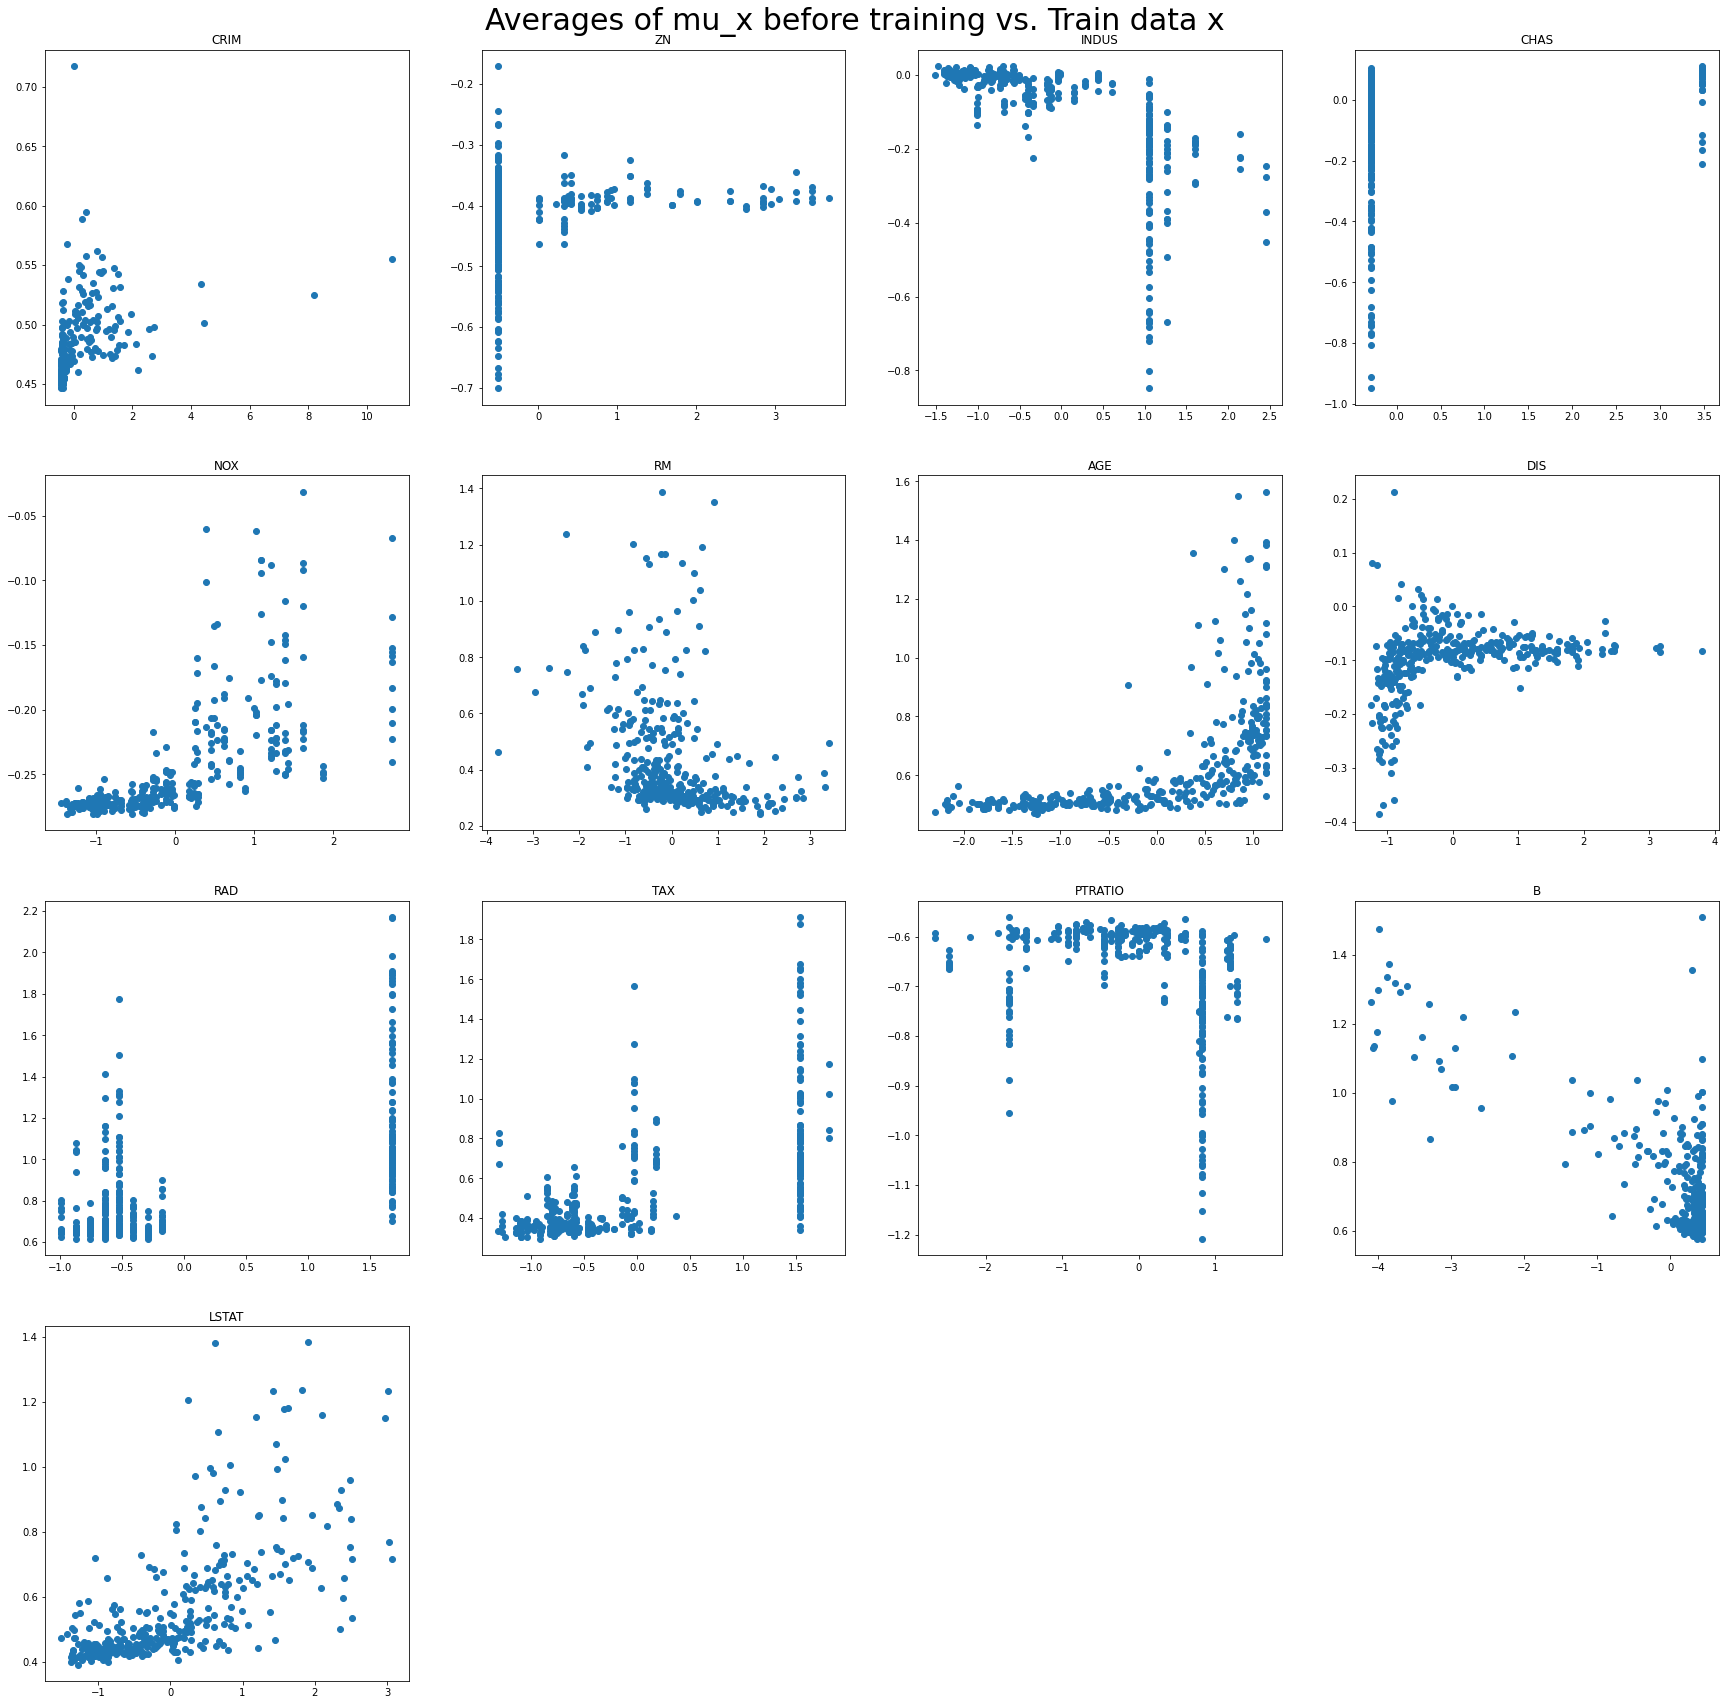

In [8]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [9]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)

In [10]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [11]:
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.1)

In [12]:
train_loss_avg = []
test_losses = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    
#     
    for x in train_iter: 
#         x = x.type(torch.float64)
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        
        mu_x, std_x = dec(z_samples)
        
        # Loss
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward 
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    scheduler.step()
    
    # Test 
    mu_z, std_z = enc(X_test)
    eps = torch.randn_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)

    mu_x, std_x = dec(z_samples)

    # Loss
    test_loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, X_test)
    
    test_losses.append(test_loss)
    
    
    print("Epoch [%d / %d] average loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 1000] average loss: 166.233127
Epoch [2 / 1000] average loss: 22.331087
Epoch [3 / 1000] average loss: 21.463397
Epoch [4 / 1000] average loss: 21.111205
Epoch [5 / 1000] average loss: 21.301859
Epoch [6 / 1000] average loss: 20.905471
Epoch [7 / 1000] average loss: 20.583374
Epoch [8 / 1000] average loss: 20.356805
Epoch [9 / 1000] average loss: 20.472995
Epoch [10 / 1000] average loss: 20.682080
Epoch [11 / 1000] average loss: 20.018310
Epoch [12 / 1000] average loss: 19.984201
Epoch [13 / 1000] average loss: 20.267036
Epoch [14 / 1000] average loss: 19.727293
Epoch [15 / 1000] average loss: 19.660734
Epoch [16 / 1000] average loss: 19.990127
Epoch [17 / 1000] average loss: 19.808963
Epoch [18 / 1000] average loss: 19.909436
Epoch [19 / 1000] average loss: 19.686354
Epoch [20 / 1000] average loss: 19.869179
Epoch [21 / 1000] average loss: 19.914546
Epoch [22 / 1000] average loss: 19.632582
Epoch [23 / 1000] average loss: 19.341979
Epoch [24 / 1000] average loss: 19.558489


Epoch [197 / 1000] average loss: 11.766605
Epoch [198 / 1000] average loss: 12.507193
Epoch [199 / 1000] average loss: 11.865801
Epoch [200 / 1000] average loss: 11.654342
Epoch [201 / 1000] average loss: 11.255311
Epoch [202 / 1000] average loss: 11.097784
Epoch [203 / 1000] average loss: 11.035547
Epoch [204 / 1000] average loss: 10.862725
Epoch [205 / 1000] average loss: 10.891338
Epoch [206 / 1000] average loss: 10.667560
Epoch [207 / 1000] average loss: 10.649644
Epoch [208 / 1000] average loss: 10.860928
Epoch [209 / 1000] average loss: 10.951686
Epoch [210 / 1000] average loss: 10.763732
Epoch [211 / 1000] average loss: 10.840556
Epoch [212 / 1000] average loss: 10.807108
Epoch [213 / 1000] average loss: 11.540242
Epoch [214 / 1000] average loss: 11.035370
Epoch [215 / 1000] average loss: 10.957396
Epoch [216 / 1000] average loss: 10.987388
Epoch [217 / 1000] average loss: 10.759052
Epoch [218 / 1000] average loss: 10.629601
Epoch [219 / 1000] average loss: 10.366284
Epoch [220 

Epoch [395 / 1000] average loss: 6.014996
Epoch [396 / 1000] average loss: 6.246082
Epoch [397 / 1000] average loss: 6.338972
Epoch [398 / 1000] average loss: 6.455365
Epoch [399 / 1000] average loss: 6.680194
Epoch [400 / 1000] average loss: 6.141865
Epoch [401 / 1000] average loss: 5.936009
Epoch [402 / 1000] average loss: 5.691653
Epoch [403 / 1000] average loss: 5.741404
Epoch [404 / 1000] average loss: 5.498074
Epoch [405 / 1000] average loss: 5.462499
Epoch [406 / 1000] average loss: 5.514145
Epoch [407 / 1000] average loss: 5.358925
Epoch [408 / 1000] average loss: 5.671387
Epoch [409 / 1000] average loss: 5.500784
Epoch [410 / 1000] average loss: 5.104491
Epoch [411 / 1000] average loss: 4.825151
Epoch [412 / 1000] average loss: 5.994654
Epoch [413 / 1000] average loss: 6.277656
Epoch [414 / 1000] average loss: 5.485122
Epoch [415 / 1000] average loss: 5.339879
Epoch [416 / 1000] average loss: 5.182676
Epoch [417 / 1000] average loss: 5.987230
Epoch [418 / 1000] average loss: 6

Epoch [594 / 1000] average loss: 3.767356
Epoch [595 / 1000] average loss: 3.817973
Epoch [596 / 1000] average loss: 3.755851
Epoch [597 / 1000] average loss: 3.432088
Epoch [598 / 1000] average loss: 3.455960
Epoch [599 / 1000] average loss: 3.618103
Epoch [600 / 1000] average loss: 3.966146
Epoch [601 / 1000] average loss: 4.860811
Epoch [602 / 1000] average loss: 3.802811
Epoch [603 / 1000] average loss: 3.804442
Epoch [604 / 1000] average loss: 3.627179
Epoch [605 / 1000] average loss: 3.618859
Epoch [606 / 1000] average loss: 3.520933
Epoch [607 / 1000] average loss: 3.772509
Epoch [608 / 1000] average loss: 4.205286
Epoch [609 / 1000] average loss: 4.297046
Epoch [610 / 1000] average loss: 3.643237
Epoch [611 / 1000] average loss: 3.560589
Epoch [612 / 1000] average loss: 3.352870
Epoch [613 / 1000] average loss: 3.443819
Epoch [614 / 1000] average loss: 3.347768
Epoch [615 / 1000] average loss: 3.505398
Epoch [616 / 1000] average loss: 3.454253
Epoch [617 / 1000] average loss: 3

Epoch [795 / 1000] average loss: 0.501932
Epoch [796 / 1000] average loss: 0.446686
Epoch [797 / 1000] average loss: 0.434195
Epoch [798 / 1000] average loss: 0.529748
Epoch [799 / 1000] average loss: 0.312166
Epoch [800 / 1000] average loss: 0.259948
Epoch [801 / 1000] average loss: 0.212403
Epoch [802 / 1000] average loss: 0.259585
Epoch [803 / 1000] average loss: 0.122047
Epoch [804 / 1000] average loss: -0.050327
Epoch [805 / 1000] average loss: 0.050054
Epoch [806 / 1000] average loss: 0.040547
Epoch [807 / 1000] average loss: -0.007458
Epoch [808 / 1000] average loss: 1.603599
Epoch [809 / 1000] average loss: 1.293515
Epoch [810 / 1000] average loss: 0.671837
Epoch [811 / 1000] average loss: 0.708594
Epoch [812 / 1000] average loss: 0.361168
Epoch [813 / 1000] average loss: 0.200340
Epoch [814 / 1000] average loss: 0.299076
Epoch [815 / 1000] average loss: 0.059199
Epoch [816 / 1000] average loss: 0.060294
Epoch [817 / 1000] average loss: 0.357804
Epoch [818 / 1000] average loss:

Epoch [991 / 1000] average loss: -1.195469
Epoch [992 / 1000] average loss: -1.022887
Epoch [993 / 1000] average loss: -1.199672
Epoch [994 / 1000] average loss: -1.281020
Epoch [995 / 1000] average loss: -1.368162
Epoch [996 / 1000] average loss: -1.273648
Epoch [997 / 1000] average loss: -1.476129
Epoch [998 / 1000] average loss: -1.470022
Epoch [999 / 1000] average loss: -1.469944
Epoch [1000 / 1000] average loss: -1.535735


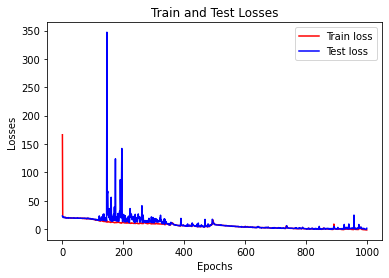

In [13]:
plt.plot(train_loss_avg, "r")
plt.plot(test_losses, "b")
plt.legend(["Train loss", "Test loss"])
plt.ylabel("Losses")
plt.xlabel("Epochs")
# plt.ylim(0, 50)
plt.title("Train and Test Losses")
plt.show()

In [14]:
avg_mu_x_trained = torch.zeros(X_train.shape)

for i in range(100):
    mu_z, std_z = enc(X_train)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_trained += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x_trained /= 100
avg_mu_x_trained.shape

torch.Size([354, 13])

## Evaluation

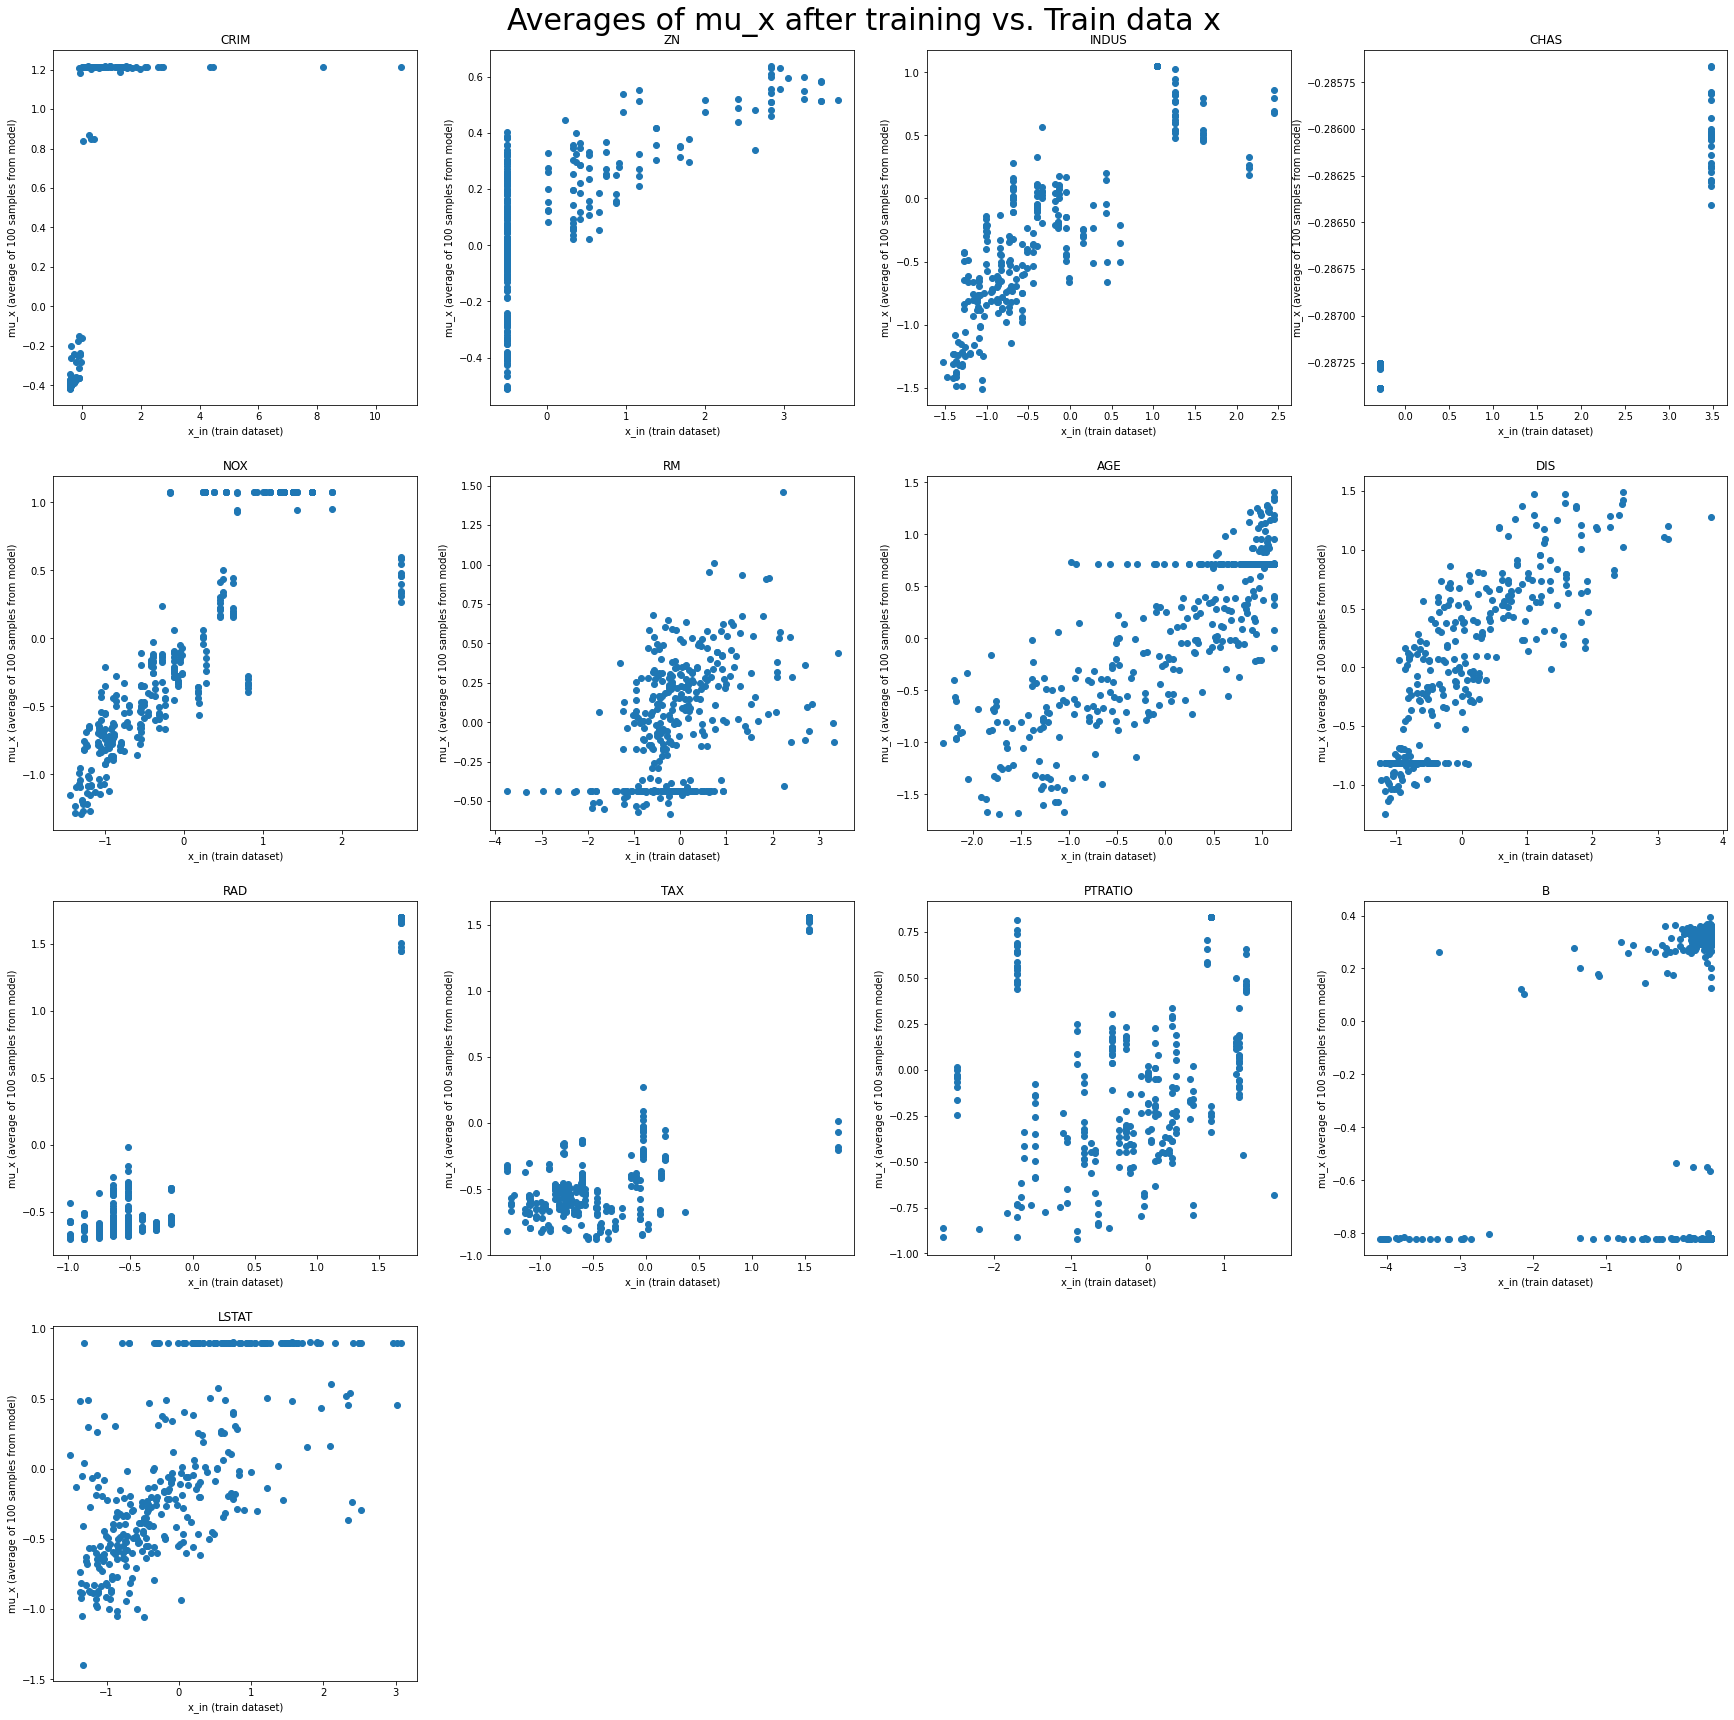

In [15]:
avg_mu_x_trained = avg_mu_x_trained.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x_trained[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [16]:
avg_mu_x_test = torch.zeros(X_test.shape)

for i in range(100):
    mu_z, std_z = enc(X_test)
    eps = torch.rand_like(std_z)
    z_samples = mu_z + eps * torch.exp(std_z)
    mu_x, std_x = dec(z_samples)
    avg_mu_x_test += mu_x
    mu_x = torch.zeros(mu_x.shape)
avg_mu_x_test /= 100
avg_mu_x_test.shape

torch.Size([152, 13])

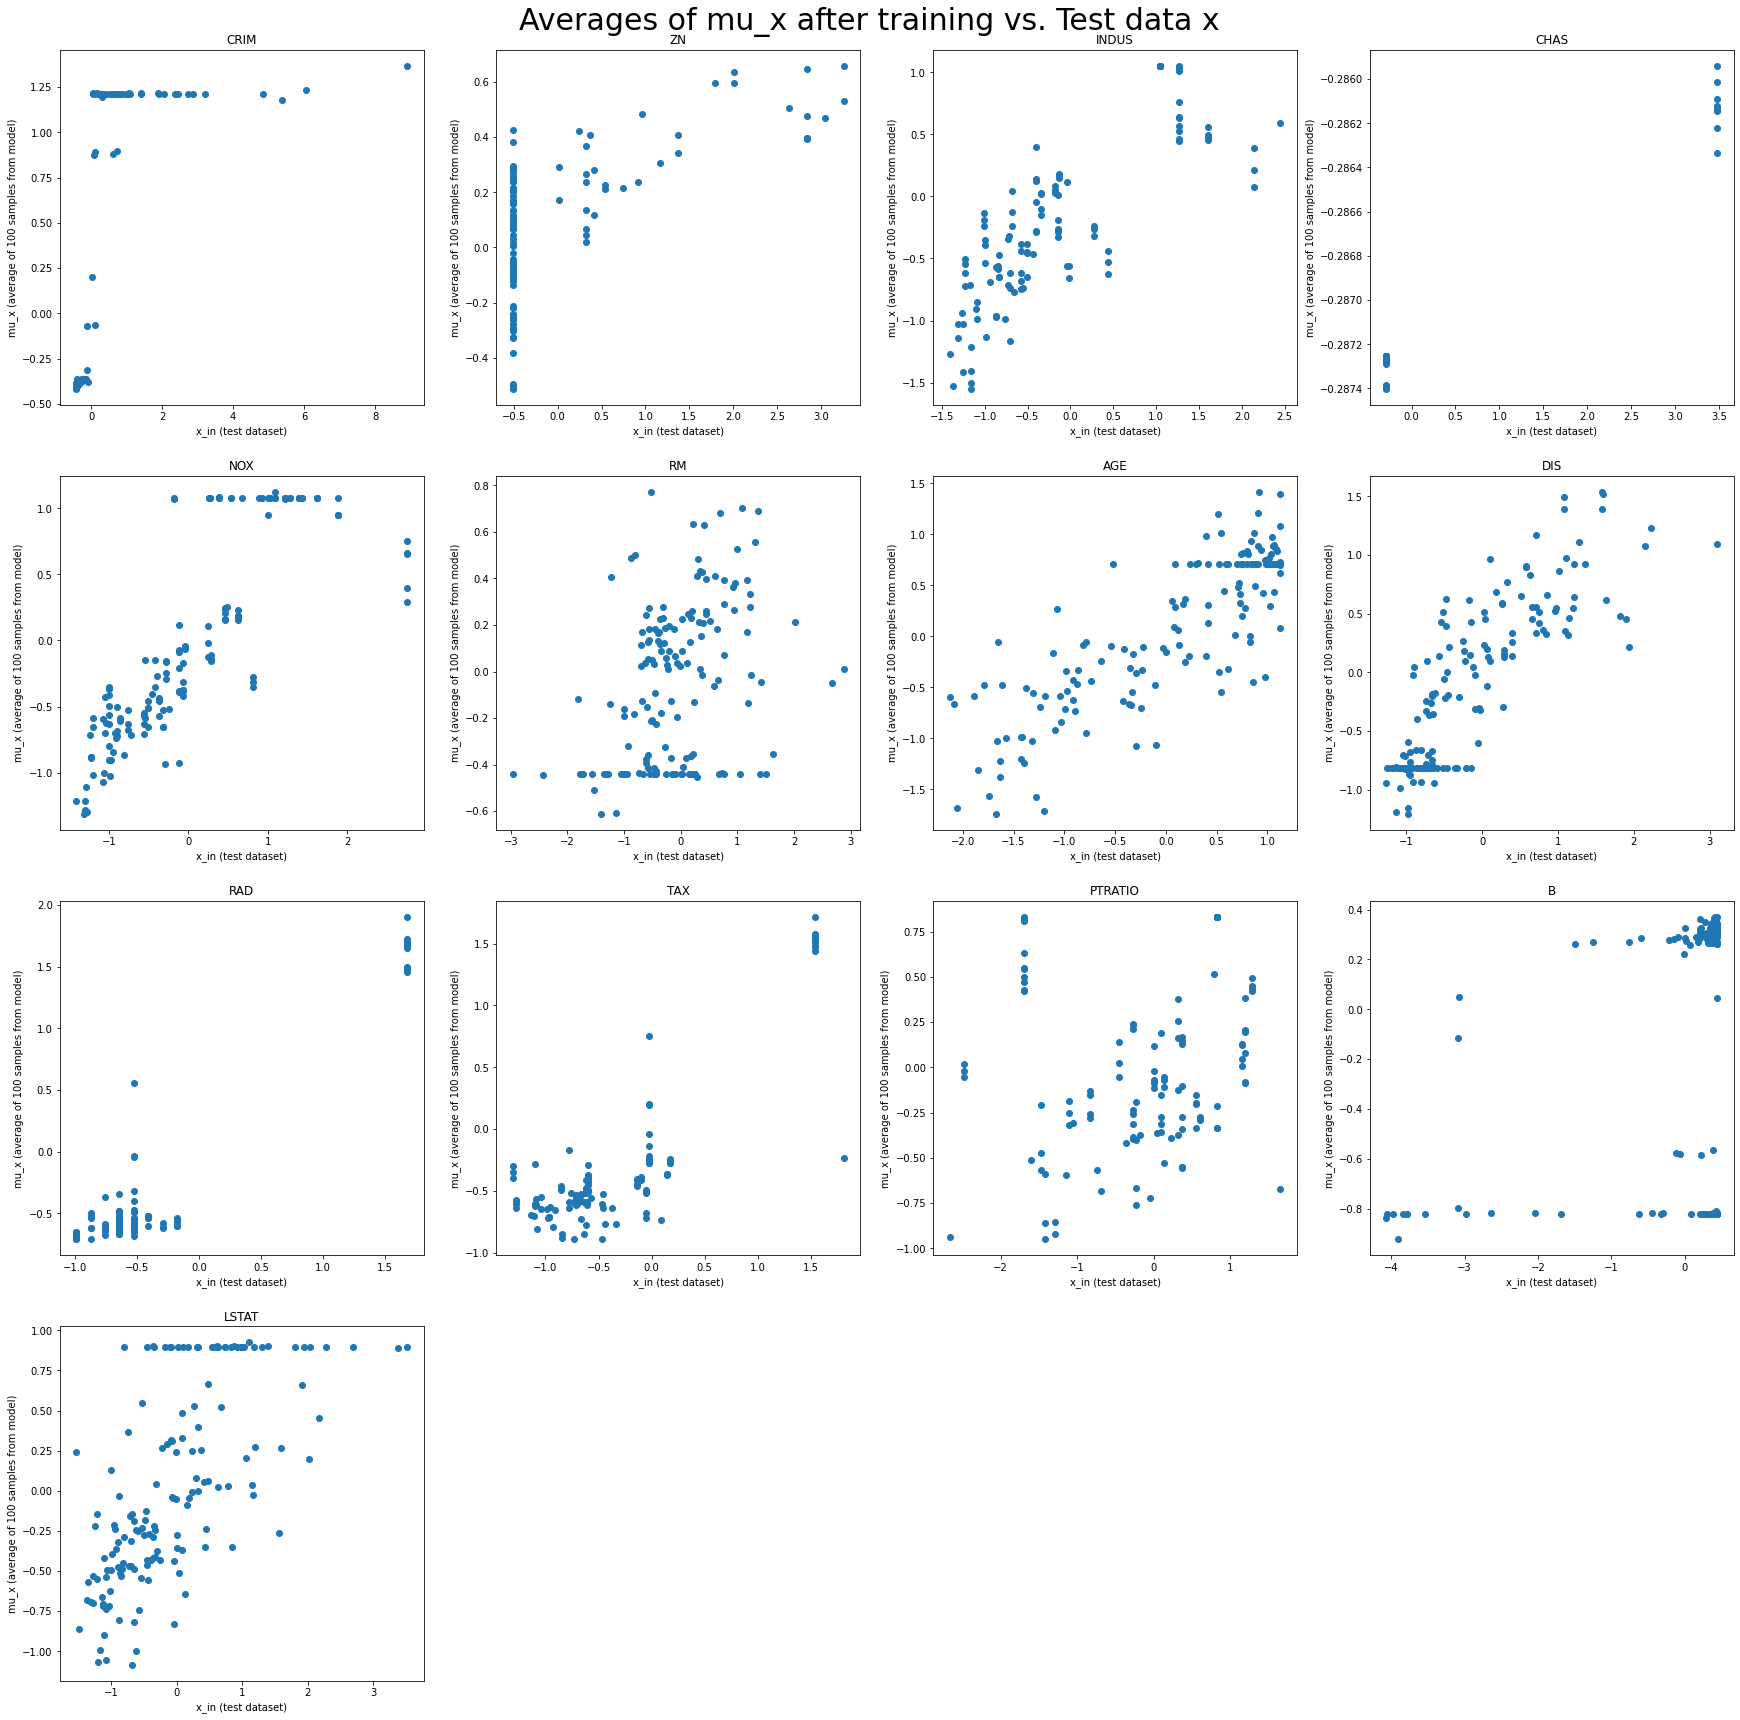

In [17]:
avg_mu_x_test = avg_mu_x_test.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_test[:,i*4+j], avg_mu_x_test[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
        axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
        axs[i, j].set_xlabel("x_in (test dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Test data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [18]:
# avg_mu_x = torch.zeros(X_train.shape)
# for i in range(100):
p_z = torch.distributions.Normal(0, 1)
z = p_z.sample((200, LATENT_DIM)).type(torch.float64)
mu_x, std_x = dec(z)
print(mu_x.shape)

torch.Size([200, 13])


(152, 13)


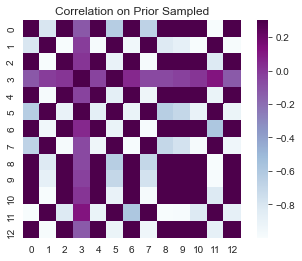

In [25]:
# mu_x = mu_x.detach().numpy()
corr_eval = np.corrcoef(mu_x, rowvar=False)
print(mu_x.shape)
import seaborn as sns
with sns.axes_style("white"):
    ax = sns.heatmap(corr_eval, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Prior Sampled")
    plt.show()

(152, 13)


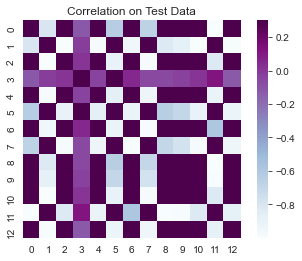

In [23]:
mu_z, std_z = enc(X_test)
eps = torch.rand_like(std_z)
z_samples = mu_z + eps * torch.exp(std_z)
mu_x, std_x = dec(z_samples)

mu_x = mu_x.detach().numpy()
corr_test = np.corrcoef(mu_x, rowvar=False)
print(mu_x.shape)
import seaborn as sns
with sns.axes_style("white"):
    ax = sns.heatmap(corr_test, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Test Data")
    plt.show()

(354, 13)


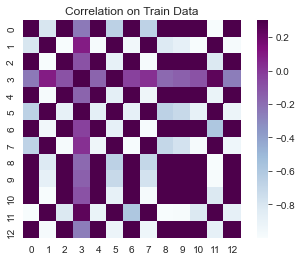

In [22]:
mu_z, std_z = enc(X_train)
eps = torch.rand_like(std_z)
z_samples = mu_z + eps * torch.exp(std_z)
mu_x, std_x = dec(z_samples)

mu_x = mu_x.detach().numpy()
corr_train = np.corrcoef(mu_x, rowvar=False)
print(mu_x.shape)
import seaborn as sns
with sns.axes_style("white"):
    ax = sns.heatmap(corr_train, vmax=.3, square=True,  cmap="BuPu")
    plt.title("Correlation on Train Data")
    plt.show()